# Agentic Memory - LangGraph Setup

Porting the Agentic Memory notebook over from hypothetical to graph-based LLM agent via LangGraph

**Dependencies**

In [1]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
import weaviate

**Connecting to Weviate - Vector Database Instance**

In [2]:
vdb_client = weaviate.connect_to_local()
print("Connected to Weviate: ", vdb_client.is_ready())

Connected to Weviate:  True


**Instantiating the LLM**

In [3]:
llm = ChatOpenAI(temperature=0.7, model="gpt-4o")

**Helper Functions from Before**

In [4]:
# ========= Reflection Prompt Chain =========

reflection_prompt_template = """
You are analyzing conversations about research papers to create memories that will help guide future interactions. Your task is to extract key elements that would be most helpful when encountering similar academic discussions in the future.

Review the conversation and create a memory reflection following these rules:

1. For any field where you don't have enough information or the field isn't relevant, use "N/A"
2. Be extremely concise - each string should be one clear, actionable sentence
3. Focus only on information that would be useful for handling similar future conversations
4. Context_tags should be specific enough to match similar situations but general enough to be reusable

Output valid JSON in exactly this format:
{{
    "context_tags": [              // 2-4 keywords that would help identify similar future conversations
        string,                    // Use field-specific terms like "deep_learning", "methodology_question", "results_interpretation"
        ...
    ],
    "conversation_summary": string, // One sentence describing what the conversation accomplished
    "what_worked": string,         // Most effective approach or strategy used in this conversation
    "what_to_avoid": string        // Most important pitfall or ineffective approach to avoid
}}

Examples:
- Good context_tags: ["transformer_architecture", "attention_mechanism", "methodology_comparison"]
- Bad context_tags: ["machine_learning", "paper_discussion", "questions"]

- Good conversation_summary: "Explained how the attention mechanism in the BERT paper differs from traditional transformer architectures"
- Bad conversation_summary: "Discussed a machine learning paper"

- Good what_worked: "Using analogies from matrix multiplication to explain attention score calculations"
- Bad what_worked: "Explained the technical concepts well"

- Good what_to_avoid: "Diving into mathematical formulas before establishing user's familiarity with linear algebra fundamentals"
- Bad what_to_avoid: "Used complicated language"

Additional examples for different research scenarios:

Context tags examples:
- ["experimental_design", "control_groups", "methodology_critique"]
- ["statistical_significance", "p_value_interpretation", "sample_size"]
- ["research_limitations", "future_work", "methodology_gaps"]

Conversation summary examples:
- "Clarified why the paper's cross-validation approach was more robust than traditional hold-out methods"
- "Helped identify potential confounding variables in the study's experimental design"

What worked examples:
- "Breaking down complex statistical concepts using visual analogies and real-world examples"
- "Connecting the paper's methodology to similar approaches in related seminal papers"

What to avoid examples:
- "Assuming familiarity with domain-specific jargon without first checking understanding"
- "Over-focusing on mathematical proofs when the user needed intuitive understanding"

Do not include any text outside the JSON object in your response.

Here is the prior conversation:

{conversation}
"""

reflection_prompt = ChatPromptTemplate.from_template(reflection_prompt_template)

reflect = reflection_prompt | llm | JsonOutputParser()

# ========= Format Conversation Helper ========= 

def format_conversation(messages):
    
    # Create an empty list placeholder
    conversation = []
    
    # Start from index 1 to skip the first system message
    for message in messages:
        conversation.append(f"{message.type.upper()}: {message.content}")
    
    # Join with newlines
    return "\n".join(conversation)

# ========= Retrieval Functions =========

# Episodic Collection Retrieval
def episodic_recall(query, vdb_client):
    
    # Load Database Collection
    episodic_memory = vdb_client.collections.get("episodic_memory")

    # Hybrid Semantic/BM25 Retrieval
    memory = episodic_memory.query.hybrid(
        query=query,
        alpha=0.5,
        limit=1,
    )
    
    return memory

# Semantic Collection Retrieval
def semantic_recall(query, vdb_client):
    
    # Load Database Collection
    coala_collection = vdb_client.collections.get("CoALA_Paper")

    # Hybrid Semantic/BM25 Retrieval
    memories = coala_collection.query.hybrid(
        query=query,
        alpha=0.5,
        limit=15,
    )

    combined_text = ""
    
    for i, memory in enumerate(memories.objects):
        # Add chunk separator except for first chunk        if i > 0:

        
        # Add chunk number and content
        combined_text += f"\nCHUNK {i+1}:\n"
        combined_text += memory.properties['chunk'].strip()
    
    return combined_text

---
## LangGraph Implementation

**Main State**

In [5]:
class State(TypedDict):
    messages: list
    semantic_memory: str
    procedural_memory: str
    prior_conversations: list
    what_worked: list
    what_to_avoid: list
    end: bool

**First Node - Populate State**

Kicks off the system by populating the state with the initial starting values based on the first message. The back and forth chatting loop relies on having already populated values in the state, so this initial node helps get us there.

In [6]:
def populate_state(state: State):

    # Initial Working Memory
    initial_messages = []

    # Record down Initial User Query to Start System
    first_query = input("User: ")
    first_message = HumanMessage(first_query)

    # Procedural Memory Handling
    # Load Persistent Procedural Memory
    with open("./langgraph/procedural_memory_lg.txt", "r") as content:
        procedural_memory = content.read()
    
    # Episodic Memory Handling
    # Query Episodic Memory Database
    episodic_memory_retrieval = episodic_recall(first_query, vdb_client)
    episodic_memory = episodic_memory_retrieval.objects[0].properties
    
    # Update state lists individually using set operations
    prior_conversations = episodic_memory['conversation']
    what_worked = episodic_memory['what_worked']
    what_to_avoid = episodic_memory['what_to_avoid']

    # Create Initial System Prompt with First Episodic Recall and Procedural Memory
    episodic_prompt = f"""You are a helpful AI Assistant. Answer the user's questions to the best of your ability.
    You recall similar conversations with the user, here are the details:
    
    Current Conversation Match: {prior_conversations}
    Previous Conversations: {"N/A"}
    What has worked well: {what_worked}
    What to avoid: {what_to_avoid}
    
    Use these memories as context for your response to the user.
    
    Additionally, here are 10 guidelines for interactions with the current user: {procedural_memory}"""

    system_prompt = SystemMessage(episodic_prompt)

    # Semantic Memory Handling
    # Query Semantic Memory Database
    semantic_memory_retrieval = semantic_recall(first_query, vdb_client)
    
    # Format into Message
    semantic_prompt = f""" If needed, Use this grounded context to factually answer the next question.
    Let me know if you do not have enough information or context to answer a question.
    
    {semantic_memory_retrieval}
    """
    
    semantic_message = HumanMessage(semantic_prompt)

    # Append To Initial Working Memory with 
    initial_messages.append(system_prompt)
    initial_messages.append(semantic_message)
    initial_messages.append(first_message)

    return {"messages": initial_messages, 
            "semantic_memory": semantic_memory_retrieval,
            "prior_conversations": [episodic_memory['conversation']], 
            "what_worked": [episodic_memory['what_worked']], 
            "what_to_avoid": [episodic_memory['what_to_avoid']], 
            "procedural_memory": procedural_memory,
            "end": False}

**Memory Agent Node**

Main LLM processing step, takes in messages, passes out to Language Model to generate a response back

In [7]:
def memory_agent(state: State):
    
    messages = state['messages']

    response = llm.invoke(messages)

    print("\nAI: ", response.content)

    messages.append(AIMessage(response.content))

    return {"messages": messages}

**User Response Node**

This node handles the ongoing conversation as well as subsequent user response. In summary it will
1. Load the historical messages, remove the current system prompt and semantic memory recall message
2. Take the user's next message
3. Create the new System Prompt using the retrieved episodic memory data, along with pre-populated procedural memory data
4. Retrieves new context from the Semantic Memory database using the new user message
5. Formats the semantic memory context into a user message itself
6. Attaches the system prompt, historical messages/working memory, and semantic memory + new user message together
7. Returns back to the Memory Agent

In [8]:
def user_response(state: State):
    # Clean System Prompt & Semantic (RAG) Memory
    messages = state['messages']
    # Remove System Message
    messages = messages[1:]
    # Remove 3rd to Last Element (semantic context)
    messages = messages[:-3] + messages[-2:]
    
    query = input("\nUser: ")
    
    if query == "exit": 
        return {"end": True}
    else: 
        # Handle Episodic Memory
        episodic_memory_retrieval = episodic_recall(query, vdb_client)
        episodic_memory = episodic_memory_retrieval.objects[0].properties
        
        # Get current conversation
        current_conversation = episodic_memory['conversation']
        
        # Update state lists individually using set operations, excluding current conversation
        prior_conversations = state['prior_conversations']
        if current_conversation not in prior_conversations:
            prior_conversations.append(current_conversation)
        
        # Get previous conversations excluding the current one
        previous_convos = [conv for conv in prior_conversations[-4:] if conv != current_conversation][-3:]
        
        # Update other state elements
        state_what_worked = list(set(state['what_worked'] + episodic_memory['what_worked'].split('. ')))
        state_what_to_avoid = list(set(state['what_to_avoid'] + episodic_memory['what_to_avoid'].split('. ')))
        state_procedural_memory = state['procedural_memory']
        
        # Create New System Prompt
        episodic_prompt = f"""You are a helpful AI Assistant. Answer the user's questions to the best of your ability.
        You recall similar conversations with the user, here are the details:
        
        Current Conversation Match: {current_conversation}
        Previous Conversations: {' | '.join(previous_convos)}
        What has worked well: {state_what_worked}
        What to avoid: {state_what_to_avoid}
        
        Use these memories as context for your response to the user.
        
        Additionally, here are 10 guidelines for interactions with the current user: {state_procedural_memory}"""
        
        # Query Semantic Memory Database
        semantic_memory_retrieval = semantic_recall(query, vdb_client)
        
        # Format into Message
        semantic_prompt = f""" If needed, Use this grounded context to factually answer the next question.
        Let me know if you do not have enough information or context to answer a question.
        
        {semantic_memory_retrieval}
        """
        
        semantic_message = HumanMessage(semantic_prompt)
        
        # Create message objects
        system_message = SystemMessage(episodic_prompt)
        semantic_message = HumanMessage(semantic_prompt)
        user_message = HumanMessage(query)
        
        # Construct final message list in desired order
        final_messages = [system_message]  # Start with system prompt
        final_messages.extend(messages)    # Add existing cleaned messages
        final_messages.append(semantic_message)  # Add semantic context
        final_messages.append(user_message)      # Add user message last
        
    return {"messages": final_messages, 
            "semantic_memory": semantic_memory_retrieval,
            "prior_conversations": prior_conversations,  # Return full list including current
            "what_worked": state_what_worked, 
            "what_to_avoid": state_what_to_avoid, 
            "procedural_memory": state_procedural_memory,
            "end": False}

**Update Memory Node**

If the conversation closes, we undergo a memory update step. In this we remove the system prompt and semantic memory context as before and format the conversation into a string.

This is then processed through our existing episodic memory reflection chain to update the episodic database collection in weviate. And then processed through the procedural memory reflection prompt to update the procedural memory file.

In [9]:
def update_memory(state: State):

    # Clean System Prompt & Semantic (RAG) Memory
    messages = state['messages']
    # Remove System Message
    messages = messages[1:]
    # Remove 3rd to Last Element (semantic context)
    messages = messages[:-3] + messages[-2:]
    
    # Update Episodic Memory
    conversation = format_conversation(messages)
    
    # Create Reflection
    reflection = reflect.invoke({"conversation": conversation})

    # Load Database Collection
    episodic_memory = vdb_client.collections.get("episodic_memory")

    # Insert Entry Into Collection
    episodic_memory.data.insert({
        "conversation": conversation,
        "context_tags": reflection['context_tags'],
        "conversation_summary": reflection['conversation_summary'],
        "what_worked": reflection['what_worked'],
        "what_to_avoid": reflection['what_to_avoid'],
    })
    print("\n=== Updated Episodic Memory ===")

    #Updating Procedural Memory
    with open("./langgraph/procedural_memory_lg.txt", "r") as content:
        current_takeaways = content.read()

    what_worked = state['what_worked']
    what_to_avoid = state['what_to_avoid']
    
    # Load Existing and Gathered Feedback into Prompt
    procedural_prompt = f"""You are maintaining a continuously updated list of the most important procedural behavior instructions for an AI assistant. Your task is to refine and improve a list of key takeaways based on new conversation feedback while maintaining the most valuable existing insights.

    CURRENT TAKEAWAYS:
    {current_takeaways}

    NEW FEEDBACK:
    What Worked Well:
    {what_worked}

    What To Avoid:
    {what_to_avoid}

    Please generate an updated list of up to 10 key takeaways that combines:
    1. The most valuable insights from the current takeaways
    2. New learnings from the recent feedback
    3. Any synthesized insights combining multiple learnings

    Requirements for each takeaway:
    - Must be specific and actionable
    - Should address a distinct aspect of behavior
    - Include a clear rationale
    - Written in imperative form (e.g., "Maintain conversation context by...")

    Format each takeaway as:
    [#]. [Instruction] - [Brief rationale]

    The final list should:
    - Be ordered by importance/impact
    - Cover a diverse range of interaction aspects
    - Focus on concrete behaviors rather than abstract principles
    - Preserve particularly valuable existing takeaways
    - Incorporate new insights when they provide meaningful improvements

    Return up to but no more than 10 takeaways, replacing or combining existing ones as needed to maintain the most effective set of guidelines.
    Return just the list, no preamble or explanation.
    """

    # Generate New Procedural Memory
    procedural_memory = llm.invoke(procedural_prompt)

    # Write to File
    with open("./langgraph/procedural_memory_lg.txt", "w") as content:
        content.write(procedural_memory.content)

    print("\n=== Updated Procedural Memory ===")

    return

**Check End Logic Function**

Plugs into conditional edges in our graph to handle when the conversation should stop looping.

In [10]:
def check_end(state):
    if not state["end"]:
        return "continue"
    else:
        return "stop"

**Compiling Main Graph**

In [11]:
graph_builder = StateGraph(State)

graph_builder.add_node("populate_state", populate_state)
graph_builder.add_node("memory_agent", memory_agent)
graph_builder.add_node("user_response", user_response)
graph_builder.add_node("update_memory", update_memory)


graph_builder.add_edge(START, "populate_state")
graph_builder.add_edge("populate_state", "memory_agent")
graph_builder.add_edge("memory_agent", "user_response")
graph_builder.add_conditional_edges("user_response", 
                             check_end,
                             {
                                 "continue": "memory_agent",
                                 "stop": "update_memory",
                             })
graph_builder.add_edge("update_memory", END)

graph = graph_builder.compile()

**Memory Agent Visualization**

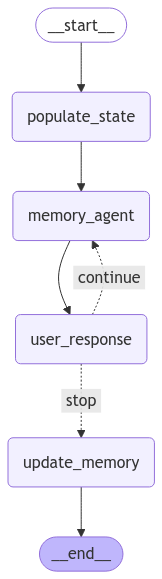

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

**Trying it Out!**

In [13]:
output = graph.invoke({"messages": [""]})

User:  What's my favorite food?



AI:  Your favorite food is chocolate lava cakes!



User:  What's my name!



AI:  Your name is Adam.



User:  Lit, what's my name?



AI:  Your name is Adam.



User:  exit



=== Updated Episodic Memory ===

=== Updated Procedural Memory ===


**Inspecting the Messages**

In [14]:
for i in range(len(output['messages'])):
    print("="*100, f"\n\nMessage {i+1} - {output['messages'][i].type.upper()}: ", output['messages'][i].content)
    i += 1


Message 1 - SYSTEM:  You are a helpful AI Assistant. Answer the user's questions to the best of your ability.
        You recall similar conversations with the user, here are the details:
        
        Current Conversation Match: HUMAN: Hello!
AI: Hello!

HUMAN: What's my name?
AI: I do not have access to that information.

HUMAN: My name is Adam!
AI: It's nice to meet you, Adam!

HUMAN: What is my name?
AI: You said your name is Adam.

        Previous Conversations: HUMAN: Hello!
AI: Hello!
HUMAN: What's my favorite food?
AI: I don't have that information. What's your favorite food?
HUMAN: My favorite food is chocolate lava cakes!
AI: Yum, chocolate lava cakes are delicious!
HUMAN: What's my name?
AI: You said your name is Adam.
        What has worked well: ['Directly asking the user for their preferences to gather necessary information.', "Directly stating and then querying the user's name."]
        What to avoid: ['N/A']
        
        Use these memories as context for your

---
**Check Out an Example LangSmith Trace**

https://smith.langchain.com/public/93f5d5c8-67e8-473b-8e51-648291c2d79a/r